In [1]:
import os
from os.path import isfile, join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MaxNLocator, MultipleLocator

In [2]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14,
    'figure.titlesize': 16
})


csv_file_path = '../metrics/exit_join_node.csv'
figure_path = '2_figures/'

METRICS_FILTER = [
    "unacked_msg",
    "stage",
    "active_peers",
    "resent"
]

TRIM_START = 0
TRIM_END = None

METRIC_DETAILS = {
    "total_sent": {"name": "Total Messages Sent", "unit": ""},
    "total_received": {"name": "Total Packets Received", "unit": ""},
    "total_mbytes_sent": {"name": "Total Data Sent", "unit": "MB"},
    "total_mbytes_received": {"name": "Total Data Received", "unit": "MB"},
    "fragments_sent": {"name": "Total Fragments Sent", "unit": ""},
    "fragments_received": {"name": "Total Fragments Received", "unit": ""},
    "resent": {"name": "Total Fragments Resent", "unit": ""},
    "forwarded": {"name": "Total Packets Forwarded", "unit": ""},
    "surb_replied": {"name": "Total SURB Replies", "unit": ""},
    "surb_received": {"name": "Total SURB Packets Received", "unit": ""},
    "errors": {"name": "Total Error Count", "unit": ""},
    "current_round": {"name": "Current Processing Round", "unit": ""},
    "accuracy": {"name": "Accuracy", "unit": "%"},
    "aggregated_accuracy": {"name": "Aggregated Accuracy", "unit": "%"},
    "cpu_total_ns": {"name": "Total CPU Time", "unit": "ns"},
    "memory_mb": {"name": "Memory Usage", "unit": "MB"},
    "active_peers": {"name": "Active Peer Count", "unit": ""},
    "deleted_cache_for_inactive": {"name": "Total Deleted Cache for Inactive Peers", "unit": ""},
    "round_time": {"name": "Round Duration", "unit": "s"},
    "unacked_msg": {"name": "Unacknowledged Packets", "unit": ""},
    "received_duplicate_msg": {"name": "Total Duplicate Packets", "unit": ""},
    "stage": {"name": "Processing Stage", "unit": ""},
    "avg_rtt": {"name": "Average Round-Trip Time", "unit": "ms"},
    "avg_msg_per_second": {"name": "Average Message Rate", "unit": "messages/s"},
    "last_rtt": {"name": "Last Round-Trip Time", "unit": "ms"},
    "covers_sent": {"name": "Total Covers Sent", "unit": ""},
    "covers_received": {"name": "Total Covers Received", "unit": ""},
    "sending_covers": {"name": "Covers in Transmission", "unit": ""},
    "sending_messages": {"name": "Messages in Transmission", "unit": ""},
    "queued_packages": {"name": "Queued Packets", "unit": ""},
    "out_interval": {"name": "Outgoing Interval", "unit": "s"},
    "sending_time": {"name": "Transmission Time", "unit": "s"},
    "total_out_interval": {"name": "Total Outgoing Interval", "unit": "s"}
}


In [3]:
def load_file(path):
    df = pd.read_csv(path, comment='#')
    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], utc=True, errors='coerce')
        bad = ts.isna()
        if bad.any():
            ts.loc[bad] = pd.to_datetime(df.loc[bad, 'timestamp'].str.replace('Z', '+00:00'), utc=True, errors='coerce')
        df = df.assign(timestamp=ts).dropna(subset=['timestamp'])
    else:
        df['timestamp'] = pd.Timestamp.utcnow()
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    return df


In [4]:
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [5]:
def last_extend(df):
    last_t = df['time_seconds'].max()
    parts = []
    for node, g in df.groupby('node'):
        g = g.sort_values('time_seconds')
        if g['time_seconds'].iat[-1] < last_t:
            parts.append(pd.concat([g, pd.DataFrame(
                {'time_seconds': [last_t], 'value': [g['value'].iat[-1]], 'node': [node],
                 'field': [g['field'].iat[0]]})], ignore_index=True))
        else:
            parts.append(g)
    return pd.concat(parts, ignore_index=True)


In [6]:
def trim(df, start, tail):
    end = df['time_seconds'].max()
    if tail is not None:
        end = max(start, end - tail)
    return df[(df['time_seconds'] >= start) & (df['time_seconds'] <= end)]


In [7]:
def plot(dataframes, out_dir):
    fields = METRICS_FILTER if METRICS_FILTER else sorted(set().union(*(d['field'].unique() for d in dataframes)))
    for field in fields:
        fig, ax = plt.subplots(figsize=(10, 3.125))
        vmin = np.inf
        vmax = -np.inf
        lines_plotted = False
        all_integers = True

        for df in dataframes:
            sel = df[df['field'] == field].copy()
            if sel.empty:
                continue
            sel = last_extend(sel)
            sel = trim(sel, TRIM_START, TRIM_END)
            for node, g in sel.groupby('node'):
                ax.plot(g['time_seconds'] / 60, g['value'], label=f"Node {node.replace('node_', '')}", linewidth=0.8)
                lines_plotted = True
                if not g['value'].dropna().empty:
                    vmin = min(vmin, g['value'].min())
                    vmax = max(vmax, g['value'].max())
                if not np.all(np.isclose(g['value'].dropna(), g['value'].dropna().round())):
                    all_integers = False

        if not lines_plotted:
            plt.close(fig)
            continue

        details = METRIC_DETAILS.get(field, {"name": field.replace('_', ' ').title(), "unit": ""})
        y_label = f"{details['name']} ({details['unit']})" if details["unit"] else details["name"]
        ax.set_title(details['name'])
        ax.set_xlabel("Time (minutes)")
        ax.set_ylabel(y_label)
        ax.grid(True, linestyle='--', alpha=0.6)

        legend = ax.legend(loc="upper left", edgecolor=None, fontsize=12)
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 1))
        for line in legend.get_lines():
            line.set_linewidth(3.0)

        ax.xaxis.set_major_locator(MultipleLocator(1))

        if np.isfinite(vmin) and np.isfinite(vmax) and vmin >= 0 and vmax <= 1:
            ax.set_ylim(0, 1)
            ax.set_yticks(np.linspace(0, 1, 10))

        if all_integers:
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        plt.savefig(join(out_dir, f"topology_{field}_per_node.pdf"), bbox_inches="tight", dpi=600)
        plt.show()


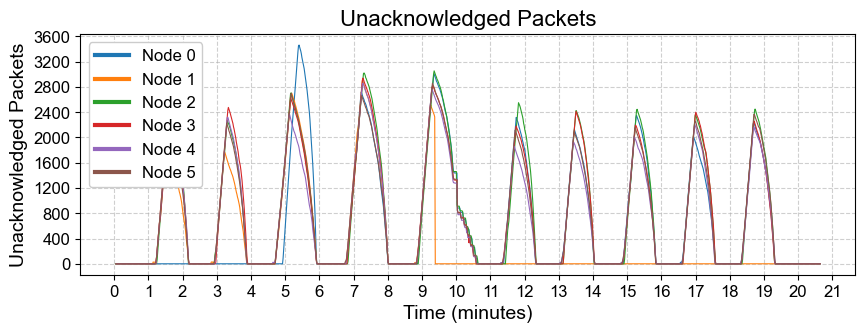

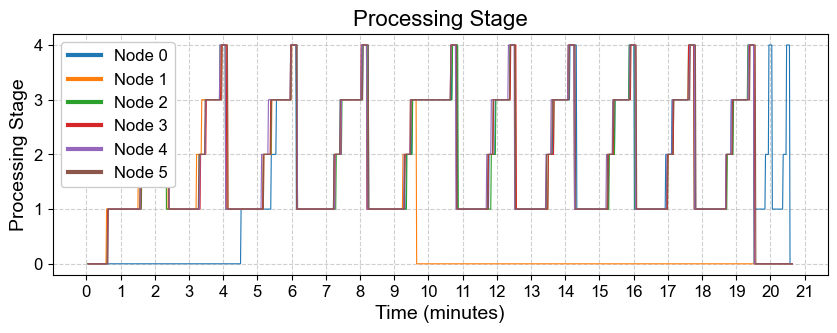

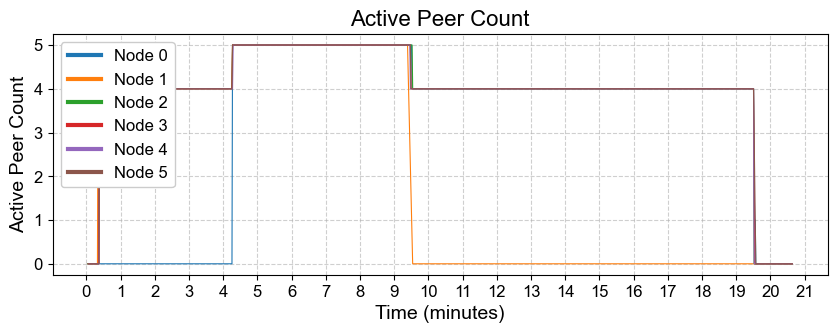

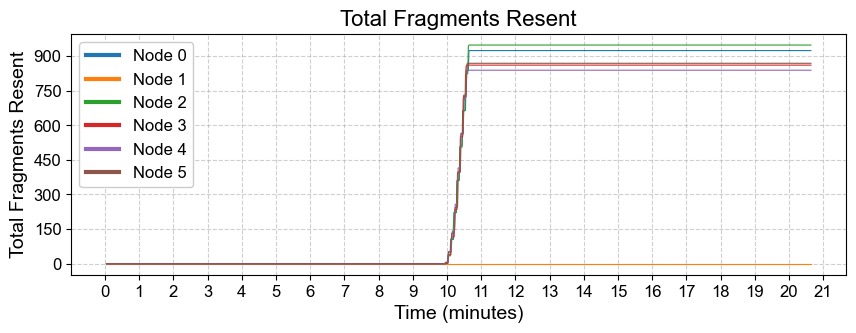

In [8]:
if __name__ == "__main__":
    if isfile(csv_file_path) and csv_file_path.lower().endswith('.csv'):
        df = load_file(csv_file_path)
        if not df.empty:
            global_start = df['timestamp'].min()
            df['time_seconds'] = (df['timestamp'] - global_start).dt.total_seconds()
            plot([df], figure_path)
    else:
        print(f"Invalid file path: {csv_file_path}.")